# July 13th, 2018
## Benjamin Adam Catching
## Andino Lab Rotation
## Polio DIPs Project

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

import skimage.filters
import skimage.morphology
import skimage.io
import skimage.segmentation
import skimage.exposure
import skimage.feature
import pprint
import scipy.ndimage

In [2]:
class Bulk_droplet:
    """Create an image object from the read in file"""
    
    def __init__(self, filename, micron_per_pixel=1, gfp_thresh=0, multi_channel=False,
                testing=False):
        """Initialize the image data"""
        
        # Define input image attributes
        self.filename = filename
        self.image = skimage.io.imread(filename)
        self.micron_per_pixel = micron_per_pixel
        self.gfp_thresh = gfp_thresh
        self.shape = self.image.shape
        self.multi_channel = multi_channel
        
    def droplet_segment(self, testing=False):
        """Return droplets and their properties"""
        
        # If the image has multiple channels, choose the channel to determine droplets from
        if self.multi_channel:
            bright_channel = int(input('Input brightfield channel: '))
            image_bright = (self.image)[:, :, bright_channel]
        else:
            image_bright = self.image

        # Find the Otsu threshold
        bright_thresh_otsu = skimage.filters.threshold_otsu(image_bright)
        
        # Label thesholded images
        bright_threshold = image_bright > bright_thresh_otsu
        image_labeled, number_labels = skimage.measure.label(bright_threshold, background=0, return_num=True)
        
        # Get the properties of the labeled regions
        image_props = skimage.measure.regionprops(image_labeled)

        # Create a blank region of the original image
        blank_background= np.zeros(image_bright.shape)

        # Go through props
        for index, prop in enumerate(image_props):
            #print(prop.area)
            # If the region properties are within the threshold
            if prop.area >= 400 and prop.eccentricity <= 0.5:
                # Select the region
                #print(index)
                temp_seg = image_labeled==index+1
                filled_seg = temp_seg
                # Add the temp region
                rad_1 = prop.major_axis_length
                rad_2 = prop.minor_axis_length
                eff_rad = (rad_1 + rad_2) / 4
                
                blank_background = blank_background + filled_seg
        
        # Fill the holes of the image
        image_droplets = scipy.ndimage.binary_fill_holes(blank_background)
        
        
        # If testing is True, show the image
        if testing:
            with sns.axes_style("dark"):
                # Define the number of pixels in a millimeter
                mm = (1 / self.micron_per_pixel) * 500

                # Define the number of ticks
                num_x_ticks = (image_bright.shape)[1] // mm + 1
                num_y_ticks = (image_bright.shape)[0] // mm + 1
                plt.imshow(image_droplets)
                plt.xticks(np.arange(0, (image_bright.shape)[1], mm), np.arange(0, num_x_ticks))
                plt.yticks(np.arange(0, (image_bright.shape)[0], mm), np.arange(0, num_y_ticks))
                plt.xlabel("x-axis (mm)")
                plt.ylabel("y-axis (mm)")
                plt.title("Segmented Droplets")
                plt.show()
            
        image_labeled, number_labels = skimage.measure.label(image_droplets, background=0, return_num=True)
        
        # Get the properties of the labeled regions
        image_props = skimage.measure.regionprops(image_labeled)

            
        return image_labeled, image_props
    
    def find_brightfield_cells(self):
        """Return the brightfield cells"""
        
        # Call the labeled black-white droplet image and the associated properties
        image_labeled, image_props = self.droplet_segment()
        
        # Define the droplet images
        labeled_droplets, number_droplets = skimage.measure.label(image_labeled, background=0, return_num=True)
        bright_droplet_props = skimage.measure.regionprops(labeled_droplets, image_bright)
        
        return labeled_droplets, bright_droplet_props

In [5]:
# Define the test series of images
HeLa_Fast_filenames = glob.glob("../../data/20180710_Microfludic_picture/HeLa_Fast/*.tif")
HeLa_Fast_filenames = sorted(HeLa_Fast_filenames)
HeLa_Fast_filenames

['../../data/20180710_Microfludic_picture/HeLa_Fast/10_40X_DIC.tif',
 '../../data/20180710_Microfludic_picture/HeLa_Fast/10_40X_sytox.tif',
 '../../data/20180710_Microfludic_picture/HeLa_Fast/1_20X_DIC.tif',
 '../../data/20180710_Microfludic_picture/HeLa_Fast/1_20X_stox.tif',
 '../../data/20180710_Microfludic_picture/HeLa_Fast/1_40X_DIC.tif',
 '../../data/20180710_Microfludic_picture/HeLa_Fast/1_40X_sytox.tif',
 '../../data/20180710_Microfludic_picture/HeLa_Fast/2_40X_DIC.tif',
 '../../data/20180710_Microfludic_picture/HeLa_Fast/2_40X_sytox.tif',
 '../../data/20180710_Microfludic_picture/HeLa_Fast/3_40X_DIC.tif',
 '../../data/20180710_Microfludic_picture/HeLa_Fast/3_40X_sytox.tif',
 '../../data/20180710_Microfludic_picture/HeLa_Fast/4_40X_DIC.tif',
 '../../data/20180710_Microfludic_picture/HeLa_Fast/4_40X_sytox.tif',
 '../../data/20180710_Microfludic_picture/HeLa_Fast/5_40X_DIC.tif',
 '../../data/20180710_Microfludic_picture/HeLa_Fast/5_40X_sytox.tif',
 '../../data/20180710_Microfludic

In [6]:
# Test the current function on the first set of images
test_image = Bulk_droplet(HeLa_Fast_filenames[2], gfp_thresh=50, multi_channel=True)

Input brightfield channel: 0


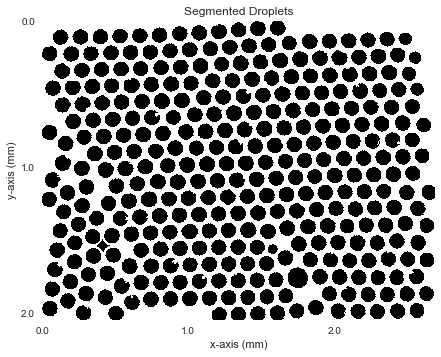

In [7]:
test_image_labeled, test_image_props = test_image.droplet_segment(testing=True)

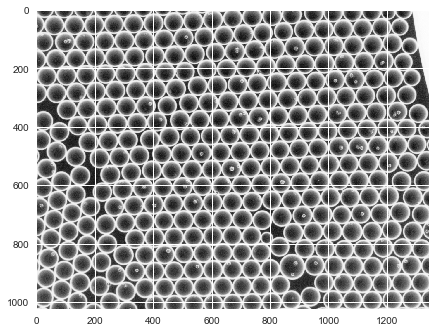

In [8]:
test_raw_image = skimage.io.imread(HeLa_Fast_filenames[2])
plt.imshow(test_raw_image[:, :, 0])
plt.show()

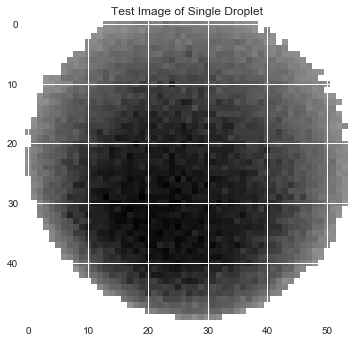

In [13]:
bright_droplet_props = skimage.measure.regionprops(test_image_labeled, test_raw_image[:, :, 0])
plt.imshow(bright_droplet_props[1].intensity_image)
plt.title("Test Image of Single Droplet")
plt.show()

There appears to be an issue that if the cell is around the exterior of the droplet, the segmentation will not include the cell in the droplet. This can be overcome by finding the effective radius of the droplet and drawing a black circle of that radius around the centroid of the droplet.

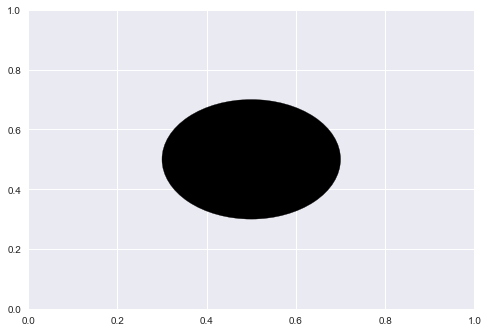

In [23]:
test_circle = plt.Circle((0.5, 0.5), 0.2, color='k')
fig, ax = plt.subplots()
ax.add_artist(test_circle)
plt.show()

This creates a circle object, but the circle has to be rasterized. The heart of the issue is generating the edge from a radius. For that the midpoint circle algorithm should be used.